# Table of Contents
- [Comparing Models](#Comparing-Models)
- [Long Document Summarizing](#Summarizing-Long-Documents)
- [Decoding Strategies + ROUGE](#Decoding-Strategies-+-ROUGE)
- [Performance (Time)](#Performance-(Time))
- [Mask Filling](#Mask-Filling)

Grabbing the TED Talks transcripts

In [112]:
import pandas as pd
df = pd.read_csv('..\\Datasets\\TEDTalksDataset\\transcripts.csv')
transcripts = df['transcript'].tolist()

# HuggingFace
### Using Pipelines
Downloading and running a model in just a few lines  
Pipelines are composed of 2 things: a Tokenizer and a Model. The Tokenizer is in charge of mapping/encoding raw text into inputs for the model. (This means we won't have to do cleaning like lemmatization for this kind of analysis) The Model is what makes predictions off of the inputs generated by the Tokenizer

In [55]:
#!pip install transformers
#!pip install sentencepiece
from transformers import pipeline

Tokenizers/Models have a max input length (in this case 1024 tokens). You will see in this section and the one below, we tell the tokenizer to truncate the raw text if it goes over this limit (Otherwise we get a bunch of indexing errors). I'm looking into what the best practices are for how to summarize long texts.

In [36]:
#The models are typically around 1 to 1.5 GB on the larger side - will show when downloading for the first time
summarizer = pipeline(task='summarization', model='facebook/bart-large-cnn', truncation=True)

In [39]:
#Grabbing a tranascript and doing some really basic cleaning since I know the TED talks include (Laughter) tags
tr = transcripts[0].replace('(Laughter)',' ')

In [38]:
summarizer(tr, max_length=500, min_length=0, do_sample=False)

[{'summary_text': "I have a big interest in education, and I think we all do. We have a huge vested interest in it, partly because it's education that's meant to take us into this future that we can't grasp. If you think of it, children starting school this year will be retiring in 2065. Nobody has a clue, despite all the expertise that's been on parade for the past four days, what the world will look like in five years' time."}]

Note: because of the truncation, the text that was used to generate this summary was only the first ~25% of the original transcript. Will see this more in the section below

### Downloading Pretrained
Uses the same models, but a bit more involved / tuneable. Pretty much the exact same stuff as above but split up into steps  
[List of models we could use](https://huggingface.co/models)  
  
BART model, see https://huggingface.co/docs/transformers/v4.23.1/en/model_doc/bart#transformers.BartForConditionalGeneration

In [2]:
from transformers import BartTokenizer, BartForConditionalGeneration

In [41]:
#The 2 components that made up our pipeline in the previous section
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

In [42]:
inputs = tokenizer(tr, max_length=1024, return_tensors="pt", truncation=True)
inputs['input_ids'] #This is how raw text gets fed into the model - to view it, we need to decode it

tensor([[    0, 12350,   662,  ...,  1537,    16,     2]])

In [43]:
#We can see the truncated transcript is about 25% the length of the original
#This is the same input that was used in the pipeline section
tokenizer.batch_decode(inputs['input_ids'])

['<s>Good morning. How are you? It\'s been great, hasn\'t it? I\'ve been blown away by the whole thing. In fact, I\'m leaving. There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we\'ve had and in all of the people here. Just the variety of it and the range of it. The second is that it\'s put us in a place where we have no idea what\'s going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don\'t you? I find this very interesting. If you\'re at a dinner party, and you say you work in education — Actually, you\'re not often at dinner parties, frankly. If you work in education, you\'re not asked. And you\'re never asked back, curiously. That\'s strange to me. But if you are, and you say to somebody, you know, they say, "What do you do

In [44]:
#Generate the summarization
summary_ids = model.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=500)

In [45]:
#Use the Tokenizer to decode the results so we can read them
tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

"I have an interest in education, and I think we all do. We have a huge vested interest in it, partly because it's education that's meant to take us into this future that we can't grasp. If you think of it, children starting school this year will be retiring in 2065. Nobody has a clue, despite all the expertise that's been on parade for the past four days, what the world will look like in five years' time."

This summary is almost exactly the same, the only difference being in the first sentence - don't know why this is happening but shouldn't have much of an impact

### More Examples
Each summarization takes ~10 seconds  
There will need to be some more cleaning done for this set, but this quick demo will do for now

In [46]:
for i in range(10,20):
    tr = transcripts[i].replace('(Laughter)','').replace('(Applause)','')
    inputs = tokenizer(tr, max_length=1024, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=500)
    print('Link: ',df.iloc[i]['url'])
    print(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])
    print('\n---------------------------------------------------------------------------------\n')

Link:  https://www.ted.com/talks/cameron_sinclair_on_open_source_architecture

The founder of a nonprofit that connects architects and designers around the world says he wants to make a difference in people's lives. He says he started the organization to get architects involved in humanitarian work. The organization has 40 chapters in 104 countries, with thousands of designers working around the globe.

---------------------------------------------------------------------------------

Link:  https://www.ted.com/talks/jehane_noujaim_inspires_a_global_day_of_film

Cameron Smith is the daughter of an American mother and an Egyptian-Lebanese-Syrian father. Smith's mother had an exchange student 40 years ago. Smith started taking pictures of her family to bring them together. She says she realized the power of the image when she went to a garbage-collecting village.

---------------------------------------------------------------------------------

Link:  https://www.ted.com/talks/larry_bri

### Testing on a Sohoni Lecture:

In [12]:
import re

In [47]:
with open("..\\Datasets\\Miscellaneous\\Sohoni Lecture.vtt") as f:
    lines = f.readlines()

In [49]:
lines

['WEBVTT\n',
 '\n',
 '0:0:0.0 --> 0:0:3.730\n',
 "<v Sohoni, Sohum>Alright, good afternoon, class. What's up? What's going on?</v>\n",
 '\n',
 '0:0:7.100 --> 0:0:7.620\n',
 '<v Bultman, Joshua>Good afternoon.</v>\n',
 '\n',
 '0:0:12.460 --> 0:0:15.790\n',
 '<v Sohoni, Sohum>Right. So today is our.</v>\n',
 '\n',
 '0:0:17.500 --> 0:0:18.210\n',
 '<v Sohoni, Sohum>Session.</v>\n',
 '\n',
 '0:0:18.370 --> 0:0:31.820\n',
 "<v Sohoni, Sohum>To review stuff and I'm happy to answer any questions. I could spend a few minutes on the last slide from the memory hierarchy set of slides if anyone is interested in that.</v>\n",
 '\n',
 '0:0:35.250 --> 0:0:37.700\n',
 '<v Sohoni, Sohum>Or I could answer any other questions anyone has.</v>\n',
 '\n',
 '0:0:49.610 --> 0:0:53.640\n',
 '<v Geoffrey, Timothy>I wonder if we could go over a Boolean simplification.</v>\n',
 '\n',
 '0:0:57.830 --> 0:0:58.260\n',
 '<v Sohoni, Sohum>OK.</v>\n',
 '\n',
 '0:1:21.240 --> 0:1:24.890\n',
 '<v Sohoni, Sohum>So you me

In [48]:
#Need to to some cleaning to remove time-stamps and name-tags
tr = []
for i, line in enumerate(lines):
    if i > 2 and (i+1) % 3 != 0 and line != '\n':
        tr.append(re.sub(r'<[^>]+>','', line))

In [50]:
tr = "".join(tr)
tr

"Alright, good afternoon, class. What's up? What's going on?\nGood afternoon.\nRight. So today is our.\nSession.\nTo review stuff and I'm happy to answer any questions. I could spend a few minutes on the last slide from the memory hierarchy set of slides if anyone is interested in that.\nOr I could answer any other questions anyone has.\nI wonder if we could go over a Boolean simplification.\nOK.\nSo you mean just the algebraic simplifications?\nMostly the algebraic stuff, but they wouldn't be upset if we did K maps as well.\nOK. Oh, open up the slide set.\nAlright so.\nThere's some properties that are useful when we do algebraic simplifications for a Boolean equations, so we've got.\nLet's let me see. Let me go back here. Oh, that's not part of this slide set now anyway, so we can go from here.\nUh, so we we've built, as an example is circuit here that says is like any automatic door if there is a person detected and.\nOr if there is a switch forcing the hold open right or if there is

In [51]:
inputs = tokenizer(tr, max_length=1024, return_tensors="pt", truncation=True)
summary_ids = model.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=500)
tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

'Class will go over algebraic simplifications for a Boolean equations. We will also go over a Boolean simplification for a K maps. We are going to use the memory hierarchy set of slides.'

Not a terrible summary for a quick demo. Maybe not as long / in-depth as we would like, but makes for a good lecture recap

# Comparing Models
Let's use a few of the most downloaded models from HuggingFace and generate a few summaries of some of Dr. Sohoni's lectures using the pipelines.  
  
If you decide to run these yourself, just know that these models can quickly add up storage space with many models being 1-2 GB.   
It appears they don't get properly cahced/deleted so you can manually delete them where they are stored:  **C:/Users/username/.cache/huggingface**  
  
Things to still consider:
- `do_sample`, `num_beams`, and `temperature` can change the [decoding method](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.generation_utils.GenerationMixin) and provide different summaries
- `min_length` and `max_length` can yield different summaries. (Having min_length too high can force the model to repeat a bunch of gabage)
- All lectures here are being truncated. Still have to look at how to summarize long documents

In [13]:
#Method for fetching and setting up .vvt files
def get_vvt(filepath):
    with open(filepath) as f:
        lines = f.readlines()
    tr = []
    for i, line in enumerate(lines):
        if i > 2 and (i+1) % 3 != 0 and line != '\n':
            tr.append(re.sub(r'<[^>]+>','', line))
    return "".join(tr)

In [14]:
t1 = get_vvt("..\\Datasets\\Miscellaneous\\Sohoni Lecture.vtt")
t2 = get_vvt("..\\Datasets\\Miscellaneous\\Sohoni Lecture 2.vtt")
t3 = get_vvt("..\\Datasets\\Miscellaneous\\Sohoni Lecture 3.vtt")
lectures = [t1, t2, t3]

## DistilBART
Collection of models from: https://huggingface.co/sshleifer/distilbart-cnn-12-6  
After some quick tests, it appears some of these models could benefit from setting the min_length parameter
<a id='DistilBART'></a>

In [5]:
distils = ['sshleifer/distilbart-xsum-12-1','sshleifer/distilbart-xsum-6-6','sshleifer/distilbart-xsum-12-3',
           'sshleifer/distilbart-xsum-9-6','sshleifer/distilbart-xsum-12-6','sshleifer/distilbart-cnn-12-3',
           'sshleifer/distilbart-cnn-12-6','sshleifer/distilbart-cnn-6-6']

In [7]:
for name in distils:
    summarizer = pipeline(task='summarization', model=name, truncation=True)
    print(name)
    for i, l in enumerate(lectures):
        print('Lecture',i+1,'summary',end=': ')
        print(summarizer(l, do_sample=False)[0]['summary_text'])
        print()
    print('-------------------------------------------------------')

sshleifer/distilbart-xsum-12-1
Lecture 1 summary:  The first of the year, there is a lot of people who want to know what is going on.

Lecture 2 summary:  I have been talking about the way we can get through, but there's a lot of time.

Lecture 3 summary:  The final exam for the first time, I've been speaking to the public on Tuesday.

-------------------------------------------------------
sshleifer/distilbart-xsum-6-6
Lecture 1 summary:  I'm sitting in my exam room at the University of Glasgow.

Lecture 2 summary:  I've been talking to a group of students at the University of Cambridge about how caches work.

Lecture 3 summary:  I'm sitting down in my office to answer a series of questions.

-------------------------------------------------------
sshleifer/distilbart-xsum-12-3
Lecture 1 summary:  Pupils at Aberystwyth University have been talking to me about algebraic simplification.

Lecture 2 summary:  I'm not feeling all that great today.

Lecture 3 summary:  The BBC's artificial 

## PEGASUS
"Pre-training with Extracted Gap-sentences for Abstractive Summarization"  
Collection of models from: https://huggingface.co/google/pegasus-xsum  
These models take a long time to run and don't give very good results for our case. (Some produce random gibberish, others appear to spit out text from news articles and papers) Might not be worth looking into
  
**Note:** each of these models is 2.28 GB  

In [8]:
pegasus = ['google/pegasus-xsum','google/pegasus-cnn_dailymail','google/pegasus-newsroom','google/pegasus-multi_news',
           'google/pegasus-gigaword','google/pegasus-wikihow','google/pegasus-reddit_tifu','google/pegasus-big_patent',
           'google/pegasus-arxiv','google/pegasus-pubmed','google/pegasus-aeslc','google/pegasus-billsum']

In [9]:
for name in pegasus:
    summarizer = pipeline(task='summarization', model=name, truncation=True)
    print(name)
    for i, l in enumerate(lectures):
        print('Lecture',i+1,'summary',end=': ')
        print(summarizer(l, do_sample=False)[0]['summary_text'])
        print()
    print('-------------------------------------------------------')

google/pegasus-xsum
Lecture 1 summary: So let's go ahead and mute yourself please. So if we take into account these conditions as they are, we get F equals HC prime or H prime PC prime. So H is going straight through, C is getting inverted and there's an end condition for age, prime, PC prime.

Lecture 2 summary: In this course we're going to be looking at caching and how it works.

Lecture 3 summary: In this week's episode of the BBC's Test Your Knowledge, BBC Test Your Knowledge presenter Chris Packham answers questions from students on the final exam of the BBC Test Your Knowledge course.

-------------------------------------------------------
google/pegasus-cnn_dailymail
Lecture 1 summary: This session focuses on the algebraic simplifications of a Boolean equation .<n>Take a look at some of the properties that are useful when we do these simplifications .<n>At the end of the session, you will be able to answer any questions you have .

Lecture 2 summary: Learn about the different 

Lecture 3 summary: A method and apparatus for increasing the throughput of a pipelined computer system. The method and apparatus may be used to increase the throughput of a pipelined computer system. The method and apparatus may be used to increase the throughput of a pipelined computer system. The method and apparatus may be used to increase the throughput of a pipelined computer system. The method and apparatus may be used to increase the throughput of a pipelined computer system. The method and apparatus may be used to increase the throughput of a pipelined computer system. The method and apparatus may be used to increase the throughput of a pipelined computer system. The method and apparatus may be used to increase the throughput of a pipelined computer system. The method and apparatus may be used to increase the throughput of a pipelined computer system. The method and apparatus may be used to increase the throughput of a pipelined computer system. The method and apparatus may be 

Lecture 3 summary: Higher Education Amendments of 2016 This bill amends the Higher Education Act of 1965 to modify the requirements for institutions of higher education to enroll students in courses related to science, mathematics, engineering, and social science. Specifically, the bill requires institutions to ensure that each course meets the requirements of a bachelor's degree related to science, mathematics, engineering, or social science.

-------------------------------------------------------


## BART samsum
These are more BART models that were trained/fine-tuned on the samsum dataset, which contains conversations  
>Model: https://huggingface.co/philschmid/bart-large-cnn-samsum  
>Dataset: https://huggingface.co/datasets/samsum  
<a id='BART_samsum'></a>

In [11]:
samsum = ['philschmid/bart-large-cnn-samsum','lidiya/bart-large-xsum-samsum']

In [12]:
for name in samsum:
    summarizer = pipeline(task='summarization', model=name, truncation=True)
    print(name)
    for i, l in enumerate(lectures):
        print('Lecture',i+1,'summary',end=': ')
        print(summarizer(l, do_sample=False)[0]['summary_text'])
        print()
    print('-------------------------------------------------------')

philschmid/bart-large-cnn-samsum
Lecture 1 summary: Today's session is to review stuff and answer any questions. The last slide from the memory hierarchy set of slides is about algebraic simplifications for a Boolean equations. C prime can be factored out of the commutative property, so it's a little bit tricky to explain how it works.

Lecture 2 summary: Last time, we looked at what the memory hierarchy is supposed to be doing. We talked about locality and how caches work. The most important thing you need to know about caches is locality and why they work. Latency is the time it takes to access something. The Miss penalty of a cache is essentially the latency of the next level. Block size is the size of the transfer between the cache and next level and it's the current levels miss penalty.

Lecture 3 summary: The practice final exam is similar to the one yesterday, except that it includes the complexity of having a block, which means you have to ignore the lower extra lower bits. In 

## Facebook BART
This was the model used in the beginning sections. Will now use it on all lectures  
More info here: https://huggingface.co/facebook/bart-large-cnn
<a id='Facebook_BART'></a>

In [13]:
summarizer = pipeline(task='summarization', model='facebook/bart-large-cnn', truncation=True)

In [17]:
for i, l in enumerate(lectures):
    print('Lecture',i+1,'summary',end=': ')
    print(summarizer(l, max_length=500, min_length=0, do_sample=False)[0]['summary_text'])
    print()

Lecture 1 summary: Professor Wright opens up the exam with a series of questions. The first question is about algebraic simplifications for a Boolean equations. The second is about a Boolean simplification of a door. The third is about how to use a key to open a door without a switch.

Lecture 2 summary: The most important thing you need to know about caching is locality and why caches work. The Miss penalty of a cache is essentially the latency of the next level. Cache size is essentially how big is the cache, like how many kilobytes?

Lecture 3 summary: The test includes the complexity of having a block, which means you gotta ignore the lower extra lower bits. The test is very similar to the activity we did yesterday, except that it includes the complex block of bits.



**Looks like these aren't as good as when we donwloaded the model/tokenizer separetly. Let's try that way again:**

In [29]:
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

In [32]:
for i, l in enumerate(lectures):
    inputs = tokenizer(l, max_length=1024, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=512)
    summary = tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    print('Lecture',i+1,'summary: \n',summary)
    print()

Lecture 1 summary: 
 Class will go over algebraic simplifications for a Boolean equations. We will also go over a Boolean simplification for a K maps. We are going to use the memory hierarchy set of slides.

Lecture 2 summary: 
 The most important thing you need to know about caching is locality and why caches work. Cache size is also again a pretty straightforward concept. The Miss penalty of a cache is essentially the latency of the next level. The block size is essentially just like how many words are we going to get for every time we access something.

Lecture 3 summary: 
 Good afternoon. Let us go through the practice final exam. Let's go through question by question.



In [34]:
for i, l in enumerate(lectures):
    inputs = tokenizer(l, max_length=1024, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=0, max_length=512)
    summary = tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    print('Lecture',i+1,'summary: \n',summary)
    print()

Lecture 1 summary: 
 Professor Wright opens up the exam with a series of questions and answers. The first question is about algebraic simplifications for a Boolean equations. The second question is a question on the properties of a Boolean simplification. The third question is on the use of the K maps.

Lecture 2 summary: 
 The most important thing you need to know about caching is locality and why caches work. The Miss penalty of a cache is essentially the latency of the next level. Cache size is essentially how big is the cache, like how many kilobytes?

Lecture 3 summary: 
 Good afternoon. How are you doing? I'm OK if we don't get to it either. But essentially it's very similar to the activity we did yesterday, except that it includes the complexity of having a block.



## Conclusions
We still have to try messing with some of the model parameters, but some models clearly outperform others. From a quick glance, these are probably our best contenders:   
- [sshleifer/distilbart-cnn-12-6](#DistilBART)
- [lidiya/bart-large-xsum-samsum](#BART_samsum) (summaries are much shorter, but can provide good recaps / overviews) 
- [facebook/bart-large-cnn](#Facebook_BART) (when not in pipeline)
  
# Summarizing Long Documents
Following [this](https://youtube.com/watch?v=78KjuKYiF6s) tutorial 
  
Essentially breaking document down into sentences and grouping sentences into chunks that fit the model's max input length  
(Do this so we don't input only part of a sentence in a chunk - would likely happen if splitting by individual words)  
Then generating a summary for each chunk

In [1]:
from transformers import BartTokenizer, BartForConditionalGeneration

In [4]:
checkpoint = 'facebook/bart-large-cnn'
model = BartForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = BartTokenizer.from_pretrained(checkpoint)

In [52]:
tokenizer.model_max_length

1024

In [6]:
#The tutorial used nltk to split the document into sentences
#We could use something else if needed, just using it for now since it is quick and easy
import nltk
nltk.download('punkt') #Punkt Sentence Tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kajan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
sentences = nltk.tokenize.sent_tokenize(t1)

In [54]:
len(sentences)

472

In [55]:
#Make sure there isn't an individual sentences that is longer than the max input length on its own 
max([len(tokenizer.tokenize(sen)) for sen in sentences])

57

**Putting everything together**

In [7]:
def long_summarize(text, min_len=0, max_len=512, beams=1, sample=False, temp=1.0, k=50, p=1.0):
    #Split document into sentences
    sentences = nltk.tokenize.sent_tokenize(text)
    length = 0
    chunk = ""
    chunks = []

    #Aggregate sentences into chunks that are < model_max_length
    for i, sen in enumerate(sentences):
        combined_length = len(tokenizer.tokenize(sen)) + length
        if combined_length <= tokenizer.max_len_single_sentence:
            chunk += sen + " "
            length = combined_length
            if i == len(sentences) - 1:
                chunks.append(chunk.strip())          
        else:
            chunks.append(chunk.strip())
            chunk = sen + " "
            length = len(tokenizer.tokenize(sen))
            
    #Generate and decode summaries for each chunk
    res = ""
    for i in [tokenizer(c, return_tensors='pt') for c in chunks]:
        summary_ids = model.generate(i["input_ids"], num_beams=beams, \
                                     min_length=min_len, max_length=max_len, \
                                     do_sample=sample, temperature=temp, top_k=k, top_p=p)
        summary = tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        #print(summary + "\n") #Could return instead, just printing for now
        res += summary + " "
    return res

In [85]:
#TED Talk
long_summarize(transcripts[0], beams=2)

I have a big interest in education, and I think we all do. We have a huge vested interest in it, partly because it's education that's meant to take us into this future that we can't grasp. Children starting school this year will be retiring in 2065. So the unpredictability, I think, is extraordinary.

The writer believes that children are born artists, but we lose that capacity as we grow up. He says that we are educating people out of their creative capacities. Every education system on Earth has the same hierarchy of subjects.

Our education system is predicated on the idea of academic ability. The whole system of public education around the world is a protracted process of university entrance. Many highly-talented, brilliant, creative people think they're not, because the thing they were good at at school wasn't valued, or was actually stigmatized. We need to radically rethink our view of intelligence.

The TED Talk celebrates the gift of the human imagination. We have to be careful

In [106]:
#Dr. Sohoni Lecture, summaries here not too useful.
long_summarize(t1, beams=10, max_len=64)

Alright, good afternoon, class. What's up? What's going on? Good afternoon. Today is our. Session. To review stuff and I'm happy to answer any questions. I could spend a few minutes on the last slide from the memory hierarchy set of slides if anyone is interested in that.

A or B prime C = A or B&A or C? So making more sense now. And we should also think there's De Morgan's laws. Let me get rid of. Is it a Flyers? So there is a few additional properties that. We we already looked at, but let me

If we had a B, prime C as another term or anything else with B prime in it, we could have a prime. C prime, like all of these terms, they would all be consumed into one term. And when you have one or anything, all those, any things don't matter.

Even when Y or Z sorry, changes from zero to 1, right? This is the change. No, no change in Z doesn't change the output. So for this term, why or the output? Sorry not why the output is entirely dependent on X if X is 1.

Before pipelining, all that in

In [108]:
#This lecture works a bit better, the chunk summaries are more focused
long_summarize(t2, beams=10, max_len=128)

The most important thing you need to know about caching is locality and why caches work. Here are some additional things that. I think you should be aware of, at least in terms of like how a cache works. The details of some of these things don't matter too much, but conceptually at the very least I'd like all S CS and CS students too.

There are various policies available, like just random like pick any block and just get rid of that or a first in first out right. Whatever we brought in first can be removed first. Or we could have something called least recently used, which by the way, is the most commonly used and the most effective strategy. And then there is least frequently used as well, which is like a cousin of least recent used.

Modulus operation we can do to figure out where in the cache a particular address is going to map. An example. Will walk through a pattern of access for the direct mapped cache, and then if we get time and I'm still up to teaching then I will go through

In [111]:
#Note the last (and maybe first) chunk here could prove useful
long_summarize(t3, beams=10, max_len=128)

Good afternoon. Let us go through the practice final exam. Uh, so I'm OK if we don't get to it either. But essentially it's very similar to the activity we did yesterday, except that it includes the complexity of having a block. All right. Any questions in general about the test before we start going through question by question starting with number 2?

If you have an instruction that has to do 500 different distinct things, you're not gonna get any value out of it. The fetch itself could be broken down into further sub stages, which would be. He indexing into a cache, doing the tag match in the cache, reading the actual data. buffer in the instruction cache.

So yes, that part will become more complicated, but the run of the mill assembler doesn't. So that's why I wasn't thinking the assembler would get more complex. Is there something to be said about like a pipeline is only as fast as its slowest component? Like if you have 500 stages then it's going to be held up by whatever the sl

# Decoding Strategies + ROUGE
Will use the long summarization from the previous sections to test out various decoding strategies  
Will also use ROUGE metrics to compare

In [6]:
import pandas as pd
from rouge import Rouge
from transformers import BartTokenizer, BartForConditionalGeneration

ROUGE = Rouge()
scores = {}
checkpoint = 'facebook/bart-large-cnn'
model = BartForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = BartTokenizer.from_pretrained(checkpoint)

In [87]:
#Rouge puts scores into a nested dictionary, this is used to format it into a dataframe
def collect_scores(strategies):
    df = pd.DataFrame(columns=['Strategy',
              'ROUGE-1 Precision', 'ROUGE-1 Recall', 'ROUGE-1 F1-Score',
              'ROUGE-2 Precision', 'ROUGE-2 Recall', 'ROUGE-2 F1-Score',
              'ROUGE-L Precision', 'ROUGE-L Recall', 'ROUGE-L F1-Score'])
    for strat in strategies:
        entry = scores[strat][0]
        df.loc[len(df.index)] = [strat] + [*(entry['rouge-1'].values())] + \
                                          [*(entry['rouge-2'].values())] + \
                                          [*(entry['rouge-l'].values())] 
    df.set_index('Strategy', inplace=True)
    return df

In [104]:
#Greedy decoding - num_beams = 1, do_sample = False
#Multinomial sampling - num_beams = 1, do_sample = True
#Beam-Search decoding - num_beams > 1, do_sample = False
#Beam-Search multinomal sampling - num_beams > 1, do_sample = True

t1_sum = long_summarize(t1, beams=1, sample=False) #Greedy Decoding (default)
scores['Greedy'] = ROUGE.get_scores(t1_sum, t1)

t1_sum = long_summarize(t1,beams=1, sample=True) #Multinomial
scores['Multinomial'] = ROUGE.get_scores(t1_sum, t1)

t1_sum = long_summarize(t1, beams=5, sample=False) #Beam decoding
scores['Beam Decoding'] = ROUGE.get_scores(t1_sum, t1)

t1_sum = long_summarize(t1, beams=5, sample=True) #Beam multinomial
scores['Beam Multinomial'] = ROUGE.get_scores(t1_sum, t1)

In [105]:
df = collect_scores(['Greedy','Multinomial','Beam Decoding','Beam Multinomial'])

In [106]:
df.head()

,ROUGE-1 Precision,ROUGE-1 Recall,ROUGE-1 F1-Score,ROUGE-2 Precision,ROUGE-2 Recall,ROUGE-2 F1-Score,ROUGE-L Precision,ROUGE-L Recall,ROUGE-L F1-Score
Strategy,,,,,,,,,
Greedy,0.162698,0.891304,0.275168,0.064376,0.710191,0.118052,0.158730,0.869565,0.268456
Multinomial,0.145833,0.735000,0.243377,0.030600,0.363014,0.056443,0.141865,0.715000,0.236755
Beam Decoding,0.213294,0.981735,0.350448,0.091513,0.910920,0.166317,0.210317,0.968037,0.345558
Beam Multinomial,0.189484,0.955000,0.316225,0.088337,0.921687,0.161222,0.189484,0.955000,0.316225


In [126]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained('pszemraj/long-t5-tglobal-base-16384-book-summary')
model = AutoModelForSeq2SeqLM.from_pretrained('pszemraj/long-t5-tglobal-base-16384-book-summary')
#May be good for non-tech
#Can analyze more rouge scores with models trained on different corpus once we grab the khan academy lectures

# Performance (Time)
How long do these models take to generate a summary  
#### Let's start with timing the different steps of summarization with our most effective model:

In [63]:
from transformers import BartTokenizer, BartForConditionalGeneration

checkpoint = 'facebook/bart-large-cnn'
model = BartForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = BartTokenizer.from_pretrained(checkpoint)

In [64]:
%%timeit
#Does encoding the input take any significant amount of time? No.
inputs = tokenizer(t1, max_length=1024, return_tensors="pt", truncation=True)

20 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
%%timeit
#Generating a single summary takes less than 10 seconds
summary_ids = model.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=500)

4.15 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%%timeit
#Let's see if summarizing long documents with chunking scales linearly with the amount of chunks
#t1 gets split into 6 chunks
long_summarize(t1, beams=2, min_len=0, max_len=500, sample=False)

32.9 s ± 2.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we expect 6 chunks to each take ~4 seconds, then we would expect the long summarization to take 6 * 4 = 24 seconds, but it seems it takes a bit longer. Maybe this time is coming from the splitting/chunking?

In [67]:
#Just the splitting/chunking part extracted from the long_summarize method
def chunk(text):
    #Split document into sentences
    sentences = nltk.tokenize.sent_tokenize(text)
    length = 0
    chunk = ""
    chunks = []

    #Aggregate sentences into chunks that are < model_max_length
    for i, sen in enumerate(sentences):
        combined_length = len(tokenizer.tokenize(sen)) + length
        if combined_length <= tokenizer.max_len_single_sentence:
            chunk += sen + " "
            length = combined_length
            if i == len(sentences) - 1:
                chunks.append(chunk.strip())          
        else:
            chunks.append(chunk.strip())
            chunk = sen + " "
            length = len(tokenizer.tokenize(sen))

In [68]:
%%timeit
#Doesn't appear to be from splitting/chunking
chunk(t1)

32.8 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
%%timeit
#As expected, decoding results doesn't take any significant amount of time either
tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

880 µs ± 2.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Conclusion: there must be some overhead between each model.generate() call that causes an extra few seconds for long summaries. Although, this isn't too bad at the end of the day. 
  
#### Now let's try timing summary generation with different num_beams:

In [70]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=1, min_length=0, max_length=512)

3.74 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=512)

4.22 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=3, min_length=0, max_length=512)

4.63 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=0, max_length=512)

6.85 s ± 266 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=5, min_length=0, max_length=512)

5.5 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=10, min_length=0, max_length=512)

8.18 s ± 201 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Now let's try the same thing with the base version of the BART model:

In [76]:
checkpoint = 'facebook/bart-base'
model = BartForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = BartTokenizer.from_pretrained(checkpoint)
inputs = tokenizer(t1, max_length=1024, return_tensors="pt", truncation=True)

In [77]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=1, min_length=0, max_length=512)

9.71 s ± 2.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=512)

15.9 s ± 326 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=3, min_length=0, max_length=512)

19.2 s ± 174 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=0, max_length=512)

25.4 s ± 360 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=5, min_length=0, max_length=512)

28.9 s ± 742 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
%%timeit
summary_ids = model.generate(inputs["input_ids"], num_beams=10, min_length=0, max_length=512)

51.2 s ± 484 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Seems that the base model takes longer to generate - this goes against what I expected, good to know

#### Let's see if running the models in the pipeline gives any performance advantage:

In [83]:
summarizer = pipeline(task='summarization', model='facebook/bart-large-cnn', truncation=True)

In [84]:
%%timeit
summarizer(t1, max_length=512, min_length=0, do_sample=False)

7.02 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is longer than if we added up the encoding, generation, and decoding steps from the first section at their worst cases. So, it seems we probably won't use pipelines at all since they restrict customization and don't boost performance.

In [1]:
import matplotlib.pyplot as plt

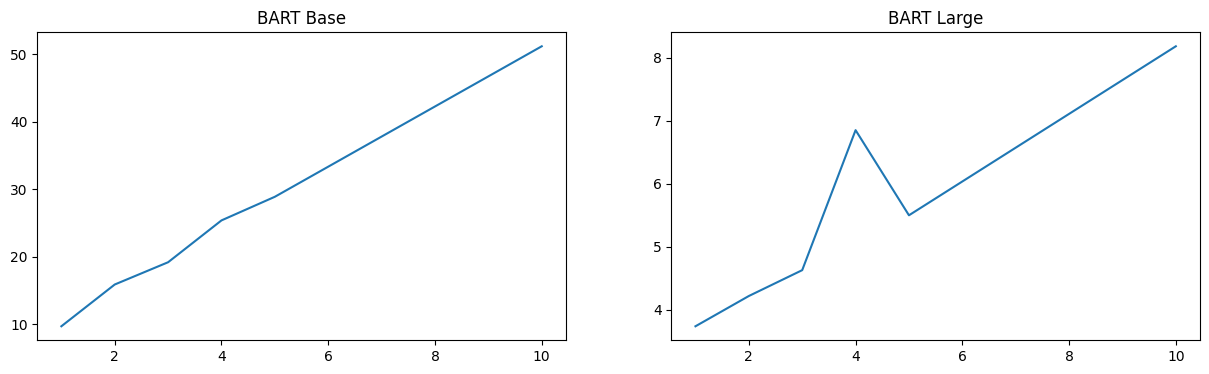

In [11]:
#Don't know how to capture output from %% magic commands, so I'm just hard-coding these graphs for quick comparison
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot([1,2,3,4,5,10],[9.71,15.9,19.2,25.4,28.9,51.2])
axes[0].title.set_text('BART Base')
axes[1].plot([1,2,3,4,5,10],[3.74,4.22,4.63,6.85,5.5,8.18])
axes[1].title.set_text('BART Large')
plt.show()

Both models seem to scale lineraly with num_beams. Not sure if we would go much further beyond 10 beams.

# Mask Filling
Looks like the facebook/bart-large-cnn checkpoint we were using previously doesn't work with mask filling, only the base or large checkpoint. Shouldn't matter though as both are accessible  
  
This is an interesting feature, however it is hard to gauge whether it will work for most/all potential questions. It mostly pulls context from the existing excerpt and tries to mirror it. Although, having quick/easy refresher questions could still prove useful for students  
  
There is also the problem of choosing which sentence/excerpt to use for these and then choosing a word to mask  
  
Note: multi-masking is possible but I don't think BART supports it. It looks like we'd need to use another model like roBERTa

In [53]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")

In [54]:
def mask_predictions(TXT):
    input_ids = tokenizer([TXT], return_tensors="pt")["input_ids"]
    logits = model(input_ids).logits
    masked_index = (input_ids[0] == tokenizer.mask_token_id).nonzero().item()
    probs = logits[0, masked_index].softmax(dim=0)
    values, predictions = probs.topk(5)

    return tokenizer.decode(predictions).split()

In [61]:
#Correct answer: 2
#It is easy to see that this example could be predicted wrong if the phrase "level 1" was used instead of "L1"
mask_predictions("The Miss penalty of a cache is essentially the latency of the next level. \
                 OK, so an L1 cache miss is going to seek data in the level 2 cache. \
                 If we find it in the level 2 cache, that Miss penalty is the latency of the level <mask> cache.")

['2', '1', '3', '4', 'that']

In [56]:
#Correct answer: block
mask_predictions("OK, so the concept of a block or where the block size comes in is essentially just like how many words.\
                 So in the level one cache. For example, if we want to store 4 words at a time, \
                 then the <mask> size would be 4 * 32")

['block', 'blocks', 'size', 'number', 'first']

In [64]:
#Correct answer: most
mask_predictions("Or we could have something called least recently used, which by the way, is the \
                 <mask> commonly used and the most effective strategy.")

['most', 'least', 'best', 'term', 'one']

In [ ]:
#TODO - more examples / picking out sentences and choosing a mask word